# Capstone Sprint 2
* Due Date: August 21, 2023
* Author: Vivasvat Kaul

## Introduction

The objective for Sprint 2 was to create an initial model using the data that was obtained and explored within Sprints 0 and 1, respectively. This notebook contains all of the relevant code of interest up to this point starting with the acquisition of the mp3 data and an exploration of the Kaggle dataset that helped obtain it. It ends with the creation of an array containing the pairwise cosine similarity for the tracks in the trianing dataset as well as a demonstration of an API call to create the playlist of similar tracks for the user.

## Load Packages

Packages relavant to th code are loaded below. Additionally, specific options or parameters are also set. For example, display options are set for `pandas` and the environment path to the environment variable file is provided for the `dotenv` package.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import sys
import pandas as pd
import numpy as np
import requests
from spotify_dl import spotify_dl
from pathlib import Path
import time
import os
from dotenv import load_dotenv # changed magic command to explicit load
import librosa
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import pairwise

pd.set_option("display.max_rows", None) # pandas dataframe formatting options
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format


custom_env_path = '../../brainstation_capstone_cfg.env' # environment variables file

In order to use the `spotify_dl` package to download the tracks that will comprise the dataset, a Spotify Web API app had to be created. From that app, the client ID and client secret were obtained and placed into the `brainstation_capstone_cfg.env` file. This file is then pulled into the present environment using the `python-dotenv` package via the magic command `%dotenv ../brainstation_capstone_cfg.env` above. The `spotify_dl` package also leverages another package known as `spotipy` and requires the `SPOTIPY_CLIENT_ID` and `SPOTIPY_CLIENT_SECRET` before it can begin downloading tracks. The credentials were stored within the external environment file which is not included within the repo for security reasons. In order to run this code, that information will be required. To obtain credentials please go to https://developer.spotify.com/documentation/web-api and follow the instructions under the 'Getting Started' section.

## Setting Environment Variables

In [2]:
# Spotify Developer Credentials
load_dotenv(dotenv_path = custom_env_path)
CLIENT_ID = os.environ.get("SPOTIPY_CLIENT_ID") 
# client ID from app
CLIENT_SECRET =  os.environ.get("SPOTIPY_CLIENT_SECRET") 
# client secret from app
REDIRECT_URI = os.environ.get('REDIRECT_URI') 
# redirect URI - the URI used here matches the one used within the app
SCOPE= "{} {}".format(os.environ.get('SCOPE_PUBLIC'),os.environ.get('SCOPE_PRIVATE'))
# formatted the scope this way to allow for custom configurations in the future
USERNAME = os.environ.get('SPOTIFY_USERNAME')
# Spotify username

## Data Acquisition

### MP3 Downloader

The code below takes the track_ids that are extracted from the Kaggle data above and loops through them. It then concatenates these track_ids with the base_url to create a url that is fed into the spotify_dl package. This package then downloads the songs as .webm files which are then converted to .mp3 files using ffmpeg (which was installed separately using the conda install -c conda-forge ffmpeg command). With ffmpeg installed, the spotify_dl package utilizes it automatically. The .mp3 files are then saved to the mp3s folder within the data directory.

This code also contains a for loop before the while block that uses the os.walk function to check the mp3s directory for track_ids that have already been downloaded. I included this code since the process of downloading the sample needed to train the model needed required multiple days worth of runtime. Effectively, this code provides some measure of resume functionality to prevent overwriting existing files or needless iteration over tracks that have already been downloaded.

In [3]:
file_path = '/Users/vii/repos/brainstation_capstone/data/mp3s/'
base_url = 'https://open.spotify.com/track/'
track_dirs =[]
dirs =[]
files = []
for root, dir, file in os.walk(file_path):
    dirs.append(dir)
    files.append(file)
    if len(dirs)>0:
        track_dirs = dirs[0].copy()
len(track_dirs)

11916

In [4]:
mp3s = [mp3[0] for mp3 in files if len(mp3)>0 and 'mp3' in mp3[0]]

In [5]:
len(mp3s)

11569

Output from code cell below looks like this:
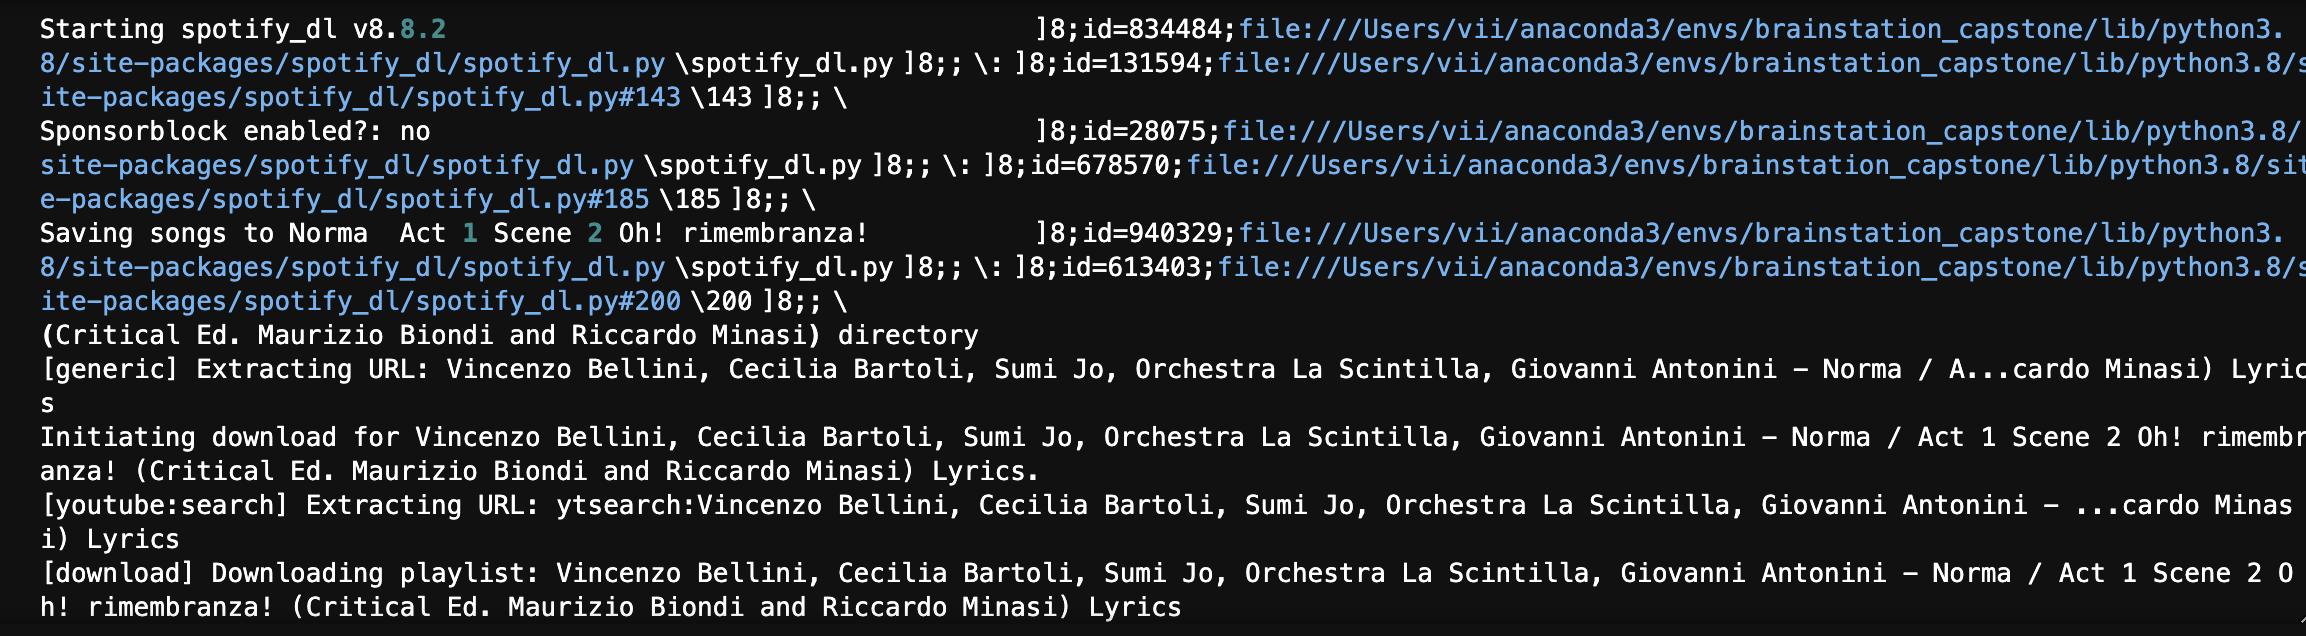

In [6]:
kaggle_df = pd.read_csv("../data/SpotifyFeatures.csv")
track_ids = kaggle_df.sample(30000, random_state = 123).track_id.str.strip().unique().tolist()
len(track_ids)

28622

In [7]:
os.system("export SPOTIPY_CLIENT_ID={}".format(CLIENT_ID))
os.system('export SPOTIPY_CLIENT_SECRET={}'.format(CLIENT_SECRET))
count = 0
while count<12000:
    for track_id in track_ids:
        if (len(track_dirs)>0) & (track_id in track_dirs):
            count+=1
            print(f'{count}: {track_id} already downloaded...skipping....')
        else:
            url = base_url+track_id    
            os.system("spotify_dl --url {} -o ../data/mp3s/{}".format(url,track_id))
            count+=1
            time.sleep(10) # 10 second delay between requests

[download] Destination: ../data/mp3s/03d0k6VDHR3YCPwWzmeFGE/Nocturne No.1 in E flat, Op.33, No.1/Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1.m4a
[download] 100% of    7.16MiB in 00:00:01 at 4.58MiB/s   
[FixupM4a] Correcting container of "../data/mp3s/03d0k6VDHR3YCPwWzmeFGE/Nocturne No.1 in E flat, Op.33, No.1/Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1.m4a"
[ExtractAudio] Destination: ../data/mp3s/03d0k6VDHR3YCPwWzmeFGE/Nocturne No.1 in E flat, Op.33, No.1/Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1.mp3
Deleting original file ../data/mp3s/03d0k6VDHR3YCPwWzmeFGE/Nocturne No.1 in E flat, Op.33, No.1/Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1.m4a (pass -k to keep)
[download] Finished downloading playlist: Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1 Lyrics
Download completed in 9.45 seconds.                            ]8;id=799585;file:///Users/vii/anaconda3/envs/brainstation_ca

KeyboardInterrupt: 

## Exploratory Data Analysis (EDA)

### Kaggle Dataset Exploration

The dataset from Kaggle is read in below. The data contains 232,725 rows which is comprised of 176,774 unique track_ids. A random sample of 30,000 rows is extracted below. From these 28,622 unique track_ids are present. The unique track_ids are stripped of trailing and leading spaces before being put into a list for looping. This list of track IDs was also useful for creating playlists within Spotify to gauge The EDA performed on this dataset is presented below.

In [37]:
kaggle_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61,0.39,99373,0.91,0.00,C#,0.35,-1.83,Major,0.05,166.97,4-Apr,0.81
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.25,0.59,137373,0.74,0.00,F#,0.15,-5.56,Minor,0.09,174.00,4-Apr,0.82
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95,0.66,170267,0.13,0.00,C,0.10,-13.88,Minor,0.04,99.49,4-May,0.37
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70,0.24,152427,0.33,0.00,C#,0.10,-12.18,Major,0.04,171.76,4-Apr,0.23
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95,0.33,82625,0.23,0.12,F,0.20,-21.15,Major,0.05,140.58,4-Apr,0.39


Conveniently, all of the columns are lowercase and have had their space characters replaced by _ characters. The info function also reveals that there are no nulls in the dataframe either as the number of non-null values is equal to the row count for the dataframe.

In [38]:
kaggle_df.shape

(232725, 18)

In [39]:
kaggle_df.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [40]:
kaggle_df.info()
# There are no nulls within the Kaggle dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [41]:
kaggle_df.genre.value_counts(normalize=True) * 100  # relatively good balance between genres

Comedy             4.16
Soundtrack         4.14
Indie              4.10
Jazz               4.06
Pop                4.03
Electronic         4.03
Children’s Music   4.02
Folk               4.00
Hip-Hop            3.99
Rock               3.98
Alternative        3.98
Classical          3.98
Rap                3.97
World              3.91
Soul               3.91
Blues              3.88
R&B                3.86
Anime              3.84
Reggaeton          3.84
Ska                3.81
Reggae             3.77
Dance              3.74
Country            3.72
Opera              3.56
Movie              3.35
Children's Music   2.32
A Capella          0.05
Name: genre, dtype: float64

Text(0.5, 1.0, 'Distribution of Genres in Kaggle Dataset')

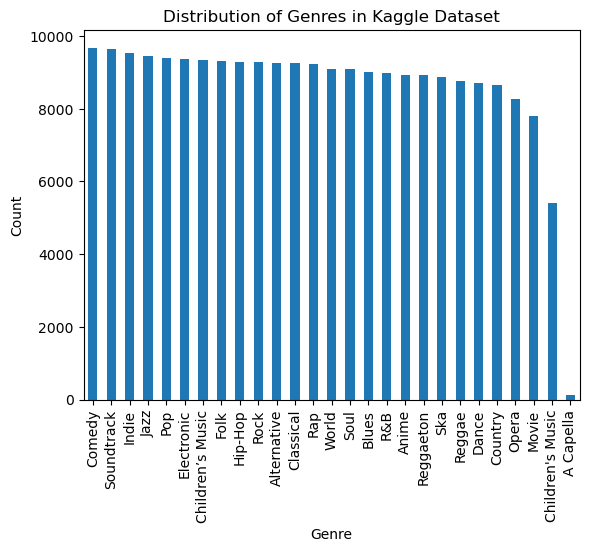

In [42]:
# Genre Distribution
plt.figure()
kaggle_df.genre.value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Genres in Kaggle Dataset')

In [43]:
kaggle_df.duration_ms.value_counts(bins=20) # most songs are of a short duration, but there are some clear outliers that are much longer

(9849.469, 292263.5]      193597
(292263.5, 569140.0]       36288
(569140.0, 846016.5]        2099
(846016.5, 1122893.0]        404
(1122893.0, 1399769.5]       150
(1399769.5, 1676646.0]        56
(1676646.0, 1953522.5]        24
(2230399.0, 2507275.5]        21
(3061028.5, 3337905.0]        14
(3337905.0, 3614781.5]        12
(2784152.0, 3061028.5]        12
(2507275.5, 2784152.0]        12
(1953522.5, 2230399.0]        12
(3614781.5, 3891658.0]         9
(4722287.5, 4999164.0]         4
(3891658.0, 4168534.5]         3
(4168534.5, 4445411.0]         3
(4445411.0, 4722287.5]         3
(5276040.5, 5552917.0]         2
(4999164.0, 5276040.5]         0
Name: duration_ms, dtype: int64

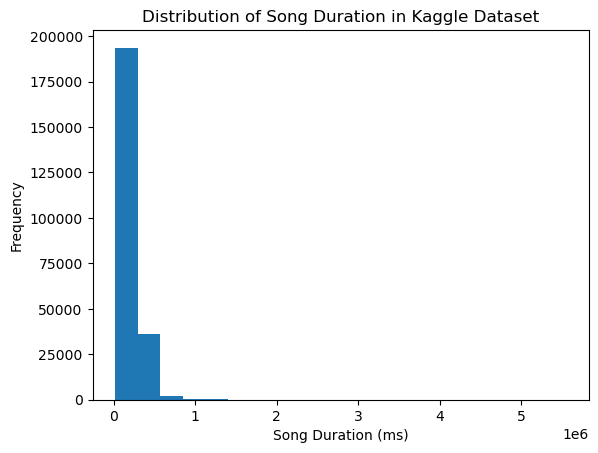

In [44]:
plt.figure()
kaggle_df.duration_ms.plot(kind = 'hist',bins = 20)
plt.xlabel('Song Duration (ms)')
plt.title('Distribution of Song Duration in Kaggle Dataset')
plt.show()

In [45]:
kaggle_df.track_id.nunique() # there are fewer track ids than there are rows

176774

In [46]:
kaggle_df.track_id.value_counts(ascending=False).head() # some of the track_ids appear more than once
# This seemed odd considering that the track_id should be a unique identifier.

3R73Y7X53MIQZWnKloWq5i    8
0wY9rA9fJkuESyYm9uzVK5    8
6sVQNUvcVFTXvlk3ec0ngd    8
0UE0RhnRaEYsiYgXpyLoZc    8
6AIte2Iej1QKlaofpjCzW1    8
Name: track_id, dtype: int64

In [47]:
kaggle_df.loc[kaggle_df.track_id == "3R73Y7X53MIQZWnKloWq5i"]
# This shows that a single track id does correspond to a single song, but that the song can repeat within the data set
# based on the genre. All of the other columns are the same though.

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
5506,Alternative,Toro y Moi,Monte Carlo (feat. WET),3R73Y7X53MIQZWnKloWq5i,50,0.08,0.65,125133,0.38,0.00,C#,0.17,-8.97,Major,0.05,140.08,4-Apr,0.13
15615,Dance,Toro y Moi,Monte Carlo (feat. WET),3R73Y7X53MIQZWnKloWq5i,61,0.08,0.65,125133,0.38,0.00,C#,0.17,-8.97,Major,0.05,140.08,4-Apr,0.13
41367,Folk,Toro y Moi,Monte Carlo (feat. WET),3R73Y7X53MIQZWnKloWq5i,61,0.08,0.65,125133,0.38,0.00,C#,0.17,-8.97,Major,0.05,140.08,4-Apr,0.13
55106,R&B,Toro y Moi,Monte Carlo (feat. WET),3R73Y7X53MIQZWnKloWq5i,61,0.08,0.65,125133,0.38,0.00,C#,0.17,-8.97,Major,0.05,140.08,4-Apr,0.13
77769,Children’s Music,Toro y Moi,Monte Carlo (feat. WET),3R73Y7X53MIQZWnKloWq5i,61,0.08,0.65,125133,0.38,0.00,C#,0.17,-8.97,Major,0.05,140.08,4-Apr,0.13
94721,Indie,Toro y Moi,Monte Carlo (feat. WET),3R73Y7X53MIQZWnKloWq5i,61,0.08,0.65,125133,0.38,0.00,C#,0.17,-8.97,Major,0.05,140.08,4-Apr,0.13
149585,Pop,Toro y Moi,Monte Carlo (feat. WET),3R73Y7X53MIQZWnKloWq5i,61,0.08,0.65,125133,0.38,0.00,C#,0.17,-8.97,Major,0.05,140.08,4-Apr,0.13
225238,Rock,Toro y Moi,Monte Carlo (feat. WET),3R73Y7X53MIQZWnKloWq5i,61,0.08,0.65,125133,0.38,0.00,C#,0.17,-8.97,Major,0.05,140.08,4-Apr,0.13


In [48]:
kaggle_df.loc[kaggle_df.track_id == "2qtoRFCOEL1gRn5q9DJC7F"]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
3042,Alternative,Frank Ocean,Solo (Reprise),2qtoRFCOEL1gRn5q9DJC7F,58,0.40,0.54,78743,0.75,0.00,G,0.09,-6.81,Minor,0.16,83.29,4-Apr,0.60
55038,R&B,Frank Ocean,Solo (Reprise),2qtoRFCOEL1gRn5q9DJC7F,63,0.40,0.54,78743,0.75,0.00,G,0.09,-6.81,Minor,0.16,83.29,4-Apr,0.60
69075,Hip-Hop,Frank Ocean,Solo (Reprise),2qtoRFCOEL1gRn5q9DJC7F,63,0.40,0.54,78743,0.75,0.00,G,0.09,-6.81,Minor,0.16,83.29,4-Apr,0.60
78415,Children’s Music,Frank Ocean,Solo (Reprise),2qtoRFCOEL1gRn5q9DJC7F,62,0.40,0.54,78743,0.75,0.00,G,0.09,-6.81,Minor,0.16,83.29,4-Apr,0.60
116591,Rap,Frank Ocean,Solo (Reprise),2qtoRFCOEL1gRn5q9DJC7F,63,0.40,0.54,78743,0.75,0.00,G,0.09,-6.81,Minor,0.16,83.29,4-Apr,0.60
149496,Pop,Frank Ocean,Solo (Reprise),2qtoRFCOEL1gRn5q9DJC7F,63,0.40,0.54,78743,0.75,0.00,G,0.09,-6.81,Minor,0.16,83.29,4-Apr,0.60
192514,Soul,Frank Ocean,Solo (Reprise),2qtoRFCOEL1gRn5q9DJC7F,63,0.40,0.54,78743,0.75,0.00,G,0.09,-6.81,Minor,0.16,83.29,4-Apr,0.60


It seems that the track_id is a unique identifier, but there are tracks that are duplicated across genre. This could be a biproduct of how the data was originally obtained.

In [49]:
kaggle_df.loc[kaggle_df.popularity > 20].sort_values(by="popularity", ascending=False).shape[
    0
] / kaggle_df.shape[0] * 100
# roughly 86% of the dataset is above a popularity score of 20
# this means that ~14% is below 20

86.06080137501343

### Librosa Spectrograms

The `librosa` package meaasures specific spectra from audio signals. The output is a vectorized signal that can then be used within a model. Below the three functions are taken from this tutorial on training a classification model using Keras from the following link:

https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/

Two examples are shown below. The first is "Take On Me" by Weezer and the second is "Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango" as performed by the London Syphony Orchestra. These tracks were selected at random from the dataset. For each track, four spectra are depicted. The information for each spectra along with a brief description and the references for each are listed below:

* Mel Spectrogram
    * Loudness profile
    * https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
    * https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html
* Chroma Vector
    * Pitch-class profile
    * https://en.wikipedia.org/wiki/Chroma_feature
    * https://librosa.org/doc/latest/generated/librosa.feature.chroma_stft.html
* Tonnal Centroid Features (Tonnetz) Spectrum
    * Harmonic relationships
    * https://en.wikipedia.org/wiki/Tonnetz
    * https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html
* Mel Sprectrum Cepstral Coefficients
    * Power spectrum coefficients (energy density of sound)
    * https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

NOTE: All of these links are also available within the README for this project.

In [59]:
def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=10, duration=60)
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc
    
def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=10, duration=60)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = np.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(file_path)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = np.concatenate( (tntz_mean, tntz_min, tntz_max) ) 
  
  feature = np.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

In [60]:
example_file = '/Users/vii/repos/brainstation_capstone/data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3'

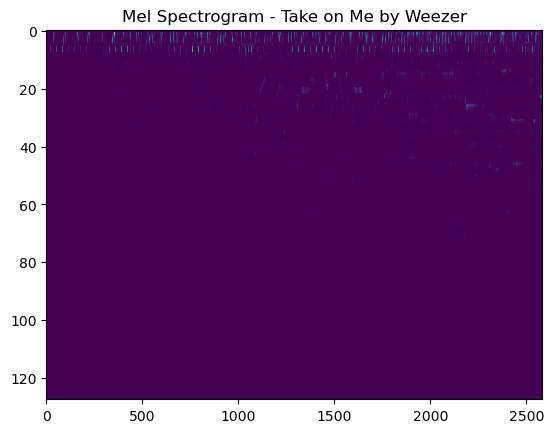

In [66]:
# Loudness Profile
# https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
# https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html
melspectrogram = get_melspectrogram(example_file)
plt.imshow(melspectrogram, interpolation='nearest', aspect='auto')
plt.title('Mel Spectrogram - Take on Me by Weezer')
plt.show()

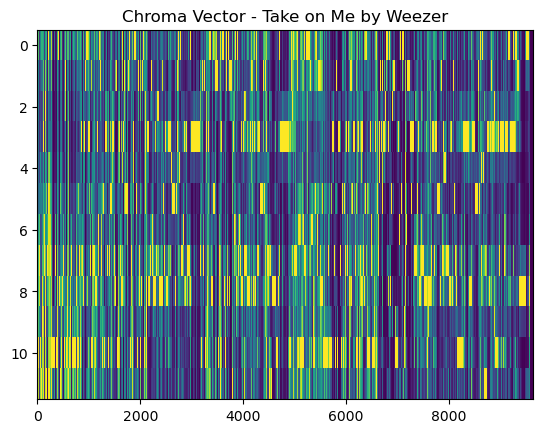

In [67]:
# Pitch-class profile
# https://en.wikipedia.org/wiki/Chroma_feature
# https://librosa.org/doc/latest/generated/librosa.feature.chroma_stft.html
chroma = get_chroma_vector(example_file)
plt.imshow(chroma, interpolation='nearest', aspect='auto')
plt.title('Chroma Vector - Take on Me by Weezer')
plt.show()

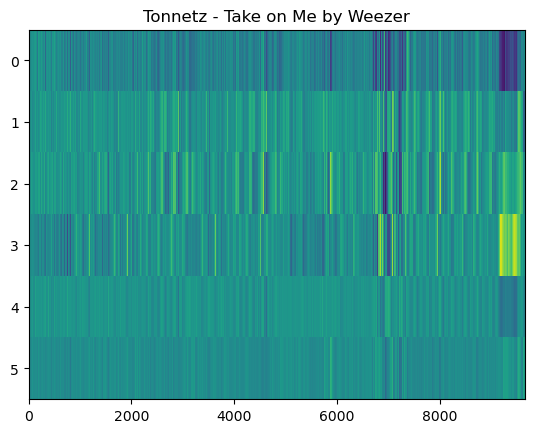

In [68]:
# Harmonic Relationships (Tonnetz)
# https://en.wikipedia.org/wiki/Tonnetz
# https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html
tntz = get_tonnetz(example_file)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.title('Tonnetz - Take on Me by Weezer')
plt.show()

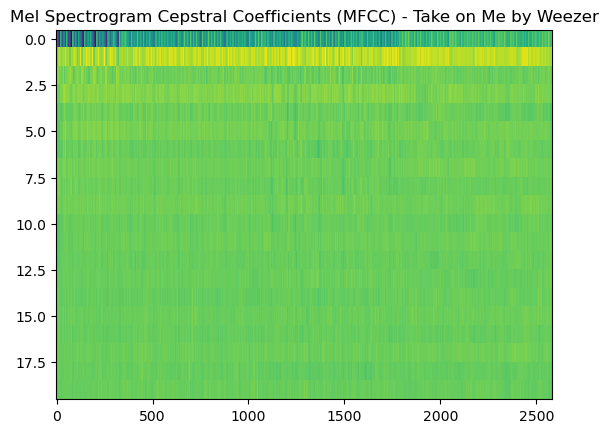

In [69]:
# Power Spectrum (Energy Density) Coefficients as plotted on Mel Scale
# https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
mfcc = get_mfcc(example_file)
plt.imshow(mfcc , interpolation='nearest', aspect='auto')
plt.title('Mel Spectrogram Cepstral Coefficients (MFCC) - Take on Me by Weezer')
plt.show()

In [55]:
example_file = '/Users/vii/repos/brainstation_capstone/data/mp3s/1cjvpB46mcjPIt9KFktKwk/Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango/Giuseppe Verdi, Sherrill Milnes, London Symphony Orchestra, Richard Bonynge - #Rigoletto # Act 2# ##Cortigiani, vil razza dannata...Ebben piango###.mp3'

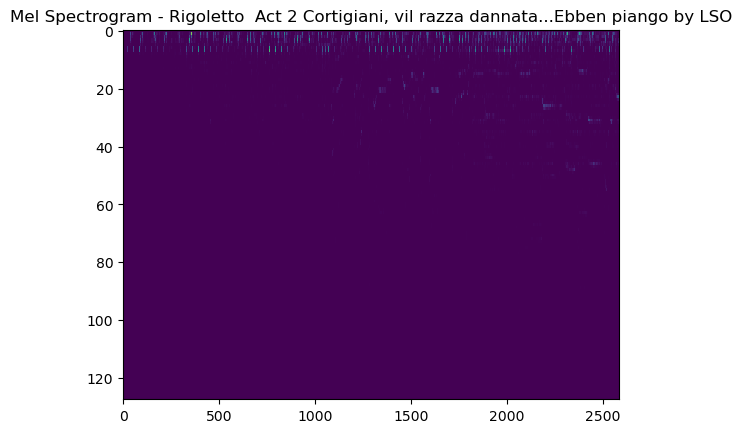

In [77]:
melspectrogram = get_melspectrogram(example_file)
plt.imshow(melspectrogram, interpolation='nearest', aspect='auto')
plt.title('Mel Spectrogram - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango by LSO')
plt.show()

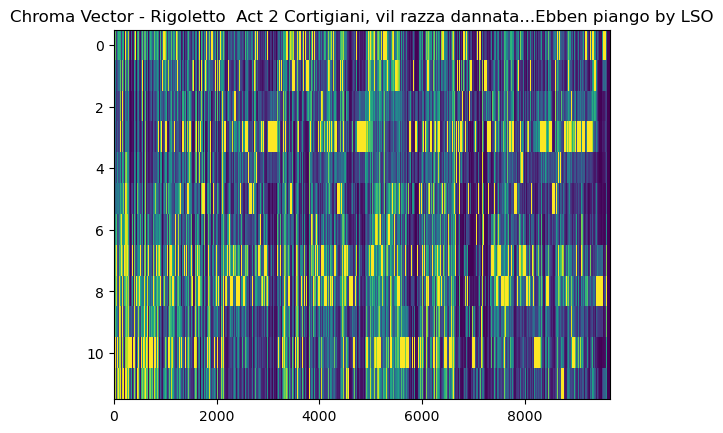

In [76]:
chroma = get_chroma_vector(example_file)
plt.imshow(chroma, interpolation='nearest', aspect='auto')
plt.title('Chroma Vector - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango by LSO')
plt.show()

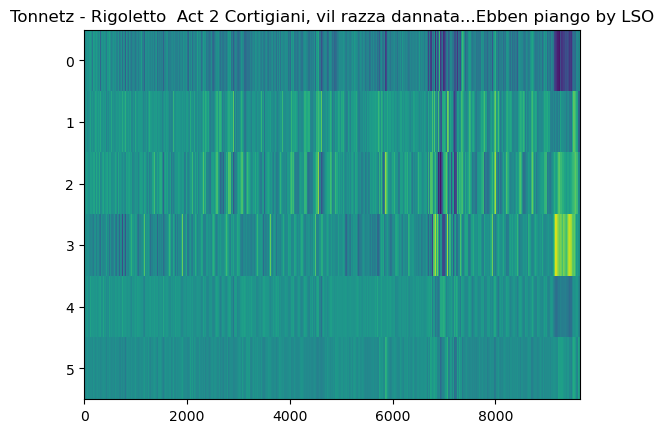

In [75]:
tntz = get_tonnetz(example_file)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.title('Tonnetz - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango by LSO')
plt.show()

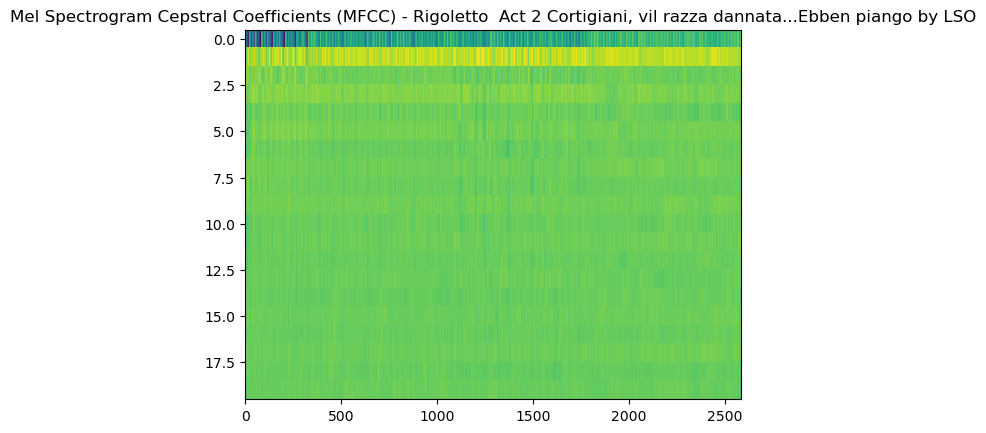

In [74]:
mfcc = get_mfcc(example_file)
plt.imshow(mfcc , interpolation='nearest', aspect='auto')
plt.title('Mel Spectrogram Cepstral Coefficients (MFCC) - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango by LSO')
plt.show()

## Vectorizing Data

The code used to vectorize the `.mp3` files is found below. First it uses a glob object from the `pathlib` library to recursively find all of the mp3s that successfully downloaded. Note that during this process two of the more than 11,000 mp3s did not download correctly from the downloader code and produced a file that could not be parsed. These files had to subsequently be deleted in order to prevent the code from halting due to errors. There is also a list created from the mp3s that have already been converted. This allows the function to have a resume functionality similar to the downloader which was implemented since it was not known initially how computationally intensive this process would be. Initially, all of the vectorized DataFrames were held in memory and concatenated at once. However, this process began to slow down over time and it was decided instead to write out each file individually and then concatenate everything back together once the vectorization had completed. An example output from the vectoziation is shown below as reference. The number indicates the count for the individual mp3 along with the file path for the vectorized data.

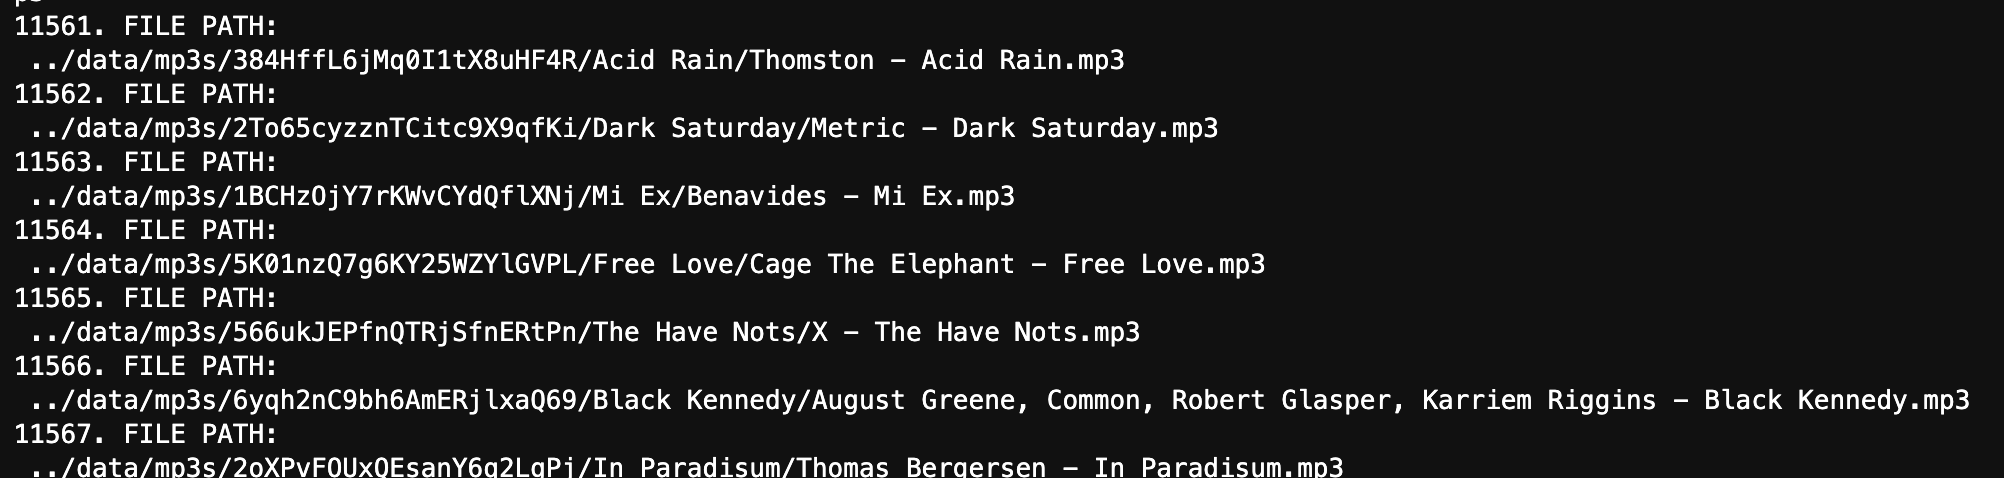

In [ ]:
data_dir = Path('../data/mp3s/')
output_dir = Path('../data/vectorized_mp3s/')
path_glob = data_dir.rglob('*.mp3')
file_paths = []
for file_path in path_glob:
    file_paths.append(file_path) # creates a list for repeated iteration
    # if this is not done, the .rglob command above has to be repeated to regenerate iterator
len(file_paths) # number of mp3s in directory

In [ ]:
data_dir = Path('../data/mp3s/')
output_dir = Path('../data/vectorized_mp3s/')
downloaded_path_glob = data_dir.rglob('*.mp3')
output_path_glob = output_dir.rglob('*.parquet')
count = 1
file_paths = [file_path for file_path in downloaded_path_glob]
print('Number of MP3 Files: ', len(file_paths),'\n')
vectorized_track_ids = [file_path.stem for file_path in output_path_glob]
for file_path in file_paths:
    print(f'{count}. FILE PATH: \n', f'{file_path}')
    path_split = str(file_path).split('/')
    track_id = path_split[3]
    if (len(vectorized_track_ids)>0) & (track_id in vectorized_track_ids):
        print(f'{track_id} has already been vectorized...skipping...')
        count+=1
    else:
        track = get_feature(file_path)
        vectorized_df = pd.DataFrame(track).T
        vectorized_df['track_id'] = track_id
        vectorized_df = vectorized_df.set_index(vectorized_df.track_id).drop(columns = 'track_id')
        vectorized_df.columns = vectorized_df.columns.astype(str)
        vectorized_df.to_parquet(f"../data/vectorized_mp3s/{track_id}.parquet")
        count+=1

In [ ]:
vectorized_data_path = Path('../data/vectorized_mp3s/')
path_glob = vectorized_data_path.rglob('*.parquet')
dataframes= []
for file_path in path_glob:
    tmp = pd.read_parquet(f'{file_path}')
    dataframes.append(tmp)
vectorized_df = pd.concat(dataframes)

In [ ]:
vectorized_df.shape

In [ ]:
output_file_date = datetime.now().strftime("%Y%m%d") # time stamps the file with the reverse of the date
vectorized_df.to_parquet(f'../data/{output_file_date}_complete_vectorized_data.parquet')

## Pairwise Cosine Similarity

Once the code above generates a complete file containing all of the vectorized mp3s, the file is read in and a pairwise cosine similarity is run using the `pairwise` function from the `sklearn.metrics` library. This array is then sorted in order from most similar to least similar. A vector is then selected from this array and a list is created from the sorted vector. Next, the sorted vector is passed into the vectorized data to extract the tracks that are most similar to the track being asked for by the user. The list is returned in the order they were ranked and the summary statistics are obtained using the `describe` function. This set of tracks can then be used to create a playlist within Spotify.

In [ ]:
vectorized_df = pd.read_parquet('../data/20230809_complete_vectorized_data.parquet')

In [ ]:
vectorized_df.shape

In [ ]:
pairwise_similarity = pairwise.cosine_similarity(vectorized_df, dense_output=True)

In [ ]:
pairwise_similarity_sorted = np.argsort(pairwise_similarity)[:,::-1]

In [ ]:
pairwise_similarity_sorted.shape

In [ ]:
pairwise_similarity_sorted

In [ ]:
vec = list(pairwise_similarity_sorted[0,0:6])
vec

In [ ]:
tracks = list(vectorized_df.iloc[vec,:].index)
tracks

In [ ]:
kaggle_df['track_id'] = kaggle_df['track_id'].astype("category")
kaggle_df['track_id'] = kaggle_df.track_id.cat.set_categories(tracks) # sets this as a category and provides a hierarchy

In [ ]:
track_recommendations = kaggle_df.copy(deep=True).sort_values(["track_id"]).head(6) # sorts heirarchy
track_recommendations

In [ ]:
track_recommendations.describe()

## Creating Recommendation Playlist

In [ ]:
# Initialize SpotifyOAuth
sp_oauth = SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=REDIRECT_URI,
    scope=SCOPE,
    cache_path=".cache",
    show_dialog=False
)

def main():
    # Get cached token or start authorization process
    access_token_info = sp_oauth.get_cached_token()
    if access_token_info:
        access_token = access_token_info['access_token']
    else:
        print("Authorization required. Visit the following URL to authorize:")
        auth_url = sp_oauth.get_authorize_url()
        print(auth_url)
        return

    # Initialize spotipy with access token
    sp = spotipy.Spotify(auth=access_token)

    # Replace 'Your Username' with your Spotify username
    username = USERNAME
    playlist_name = 'My AWESOME Playlist 2'
    playlist_description = 'Demo for Paul'

    try:
        # Create a blank playlist
        playlist = sp.user_playlist_create(
            user=username,
            name=playlist_name,
            description = playlist_description,
            public=False
        )
        print(f"Playlist '{playlist_name}' was created")
    except spotipy.SpotifyException as e:
        print(f"An error occurred: {e}")
    
if __name__ == '__main__':
    main()